In [1]:

# %pip install tensorflow


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras import layers
# from tensorflow.keras import layers
# from tensorflow.keras import Model
from os import getcwd

In [3]:
work_path = f"C:/Users/junwi/source/sandpit/cnn_lawrence/"

In [4]:
path_inception = work_path + f"tmp2/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None) 

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False 
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [6]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [21]:
from keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

c:\Users\junwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 16, 16, 48)   0           ['batch_normalization_20[0][0]'] 
                                                                                                  
 activation_23 (Activation)     (None, 16, 16, 96)   0           ['batch_normalization_23[0][0]'] 
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 16, 16, 288)  0          ['mixed1[0][0]']                 
 oling2D) 

In [22]:
# Get the Horse or Human dataset
path_horse_or_human = f"C:/Users/junwi/Downloads/horse-or-human.zip"
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = f"C:/Users/junwi/Downloads/validation-horse-or-human.zip"
from keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import shutil

shutil.rmtree(work_path +'tmp')
local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(work_path + 'tmp/training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(work_path + 'tmp/validation')
zip_ref.close()

In [23]:
# Define our example directories and files
train_dir = work_path +'tmp/training'
validation_dir = work_path +'tmp/validation'

train_horses_dir = train_dir + '/horses'
train_humans_dir = train_dir +  '/humans'
validation_horses_dir = validation_dir + '/horses'
validation_humans_dir = validation_dir + '/humans'

train_horses_fnames = os.listdir(train_horses_dir) 
train_humans_fnames = os.listdir(train_humans_dir) 
validation_horses_fnames = os.listdir(validation_horses_dir) 
validation_humans_fnames = os.listdir(validation_humans_dir) 

print(len(train_horses_fnames))
print(len(train_humans_fnames)) 
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


    rescale: This rescales the pixel values of the images so that they are between 0 and 1. This is a common preprocessing step for image data, as it can make it easier for the model to learn the underlying patterns in the data.

    rotation_range: This randomly rotates the images by a certain number of degrees. In this case, the range is set to 40 degrees, which means that the images can be rotated by up to 40 degrees in either direction.

    width_shift_range and height_shift_range: These randomly shift the images horizontally and vertically by a certain percentage of their width and height. In this case, the range is set to 0.2, which means that the images can be shifted by up to 20% of their width or height.

    shear_range: This randomly applies a shear transformation to the images, which distorts them along one axis while keeping the other axis fixed. In this case, the range is set to 0.2, which means that the images can be sheared by up to 20% of their width or height.

    zoom_range: This randomly applies a zoom transformation to the images, which either zooms in or out on the image. In this case, the range is set to 0.2, which means that the images can be zoomed in or out by up to 20%.

    horizontal_flip: This randomly flips the images horizontally. This can help introduce more variety in the training data, as it effectively doubles the number of images by providing a mirror image for each original image.

In [39]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True))

train_datagen2 = ImageDataGenerator( rescale = 1.0/255., rotation_range = 40, width_shift_range = 0.2,
                                    height_shift_range = 0.2, shear_range = 0.2,
                                    zoom_range = 0.2, horizontal_flip = True)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen2.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))

# Note that the validation data should not be augmented!
#test_datagen = ImageDataGenerator( rescale = 1.0/255.  )
validation_datagen = ImageDataGenerator( rescale = 1.0/255.  )


validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150, 150),
                                                              batch_size=20,
                                                              class_mode='binary')


# Flow validation images in batches of 20 using test_datagen generator
#validation_generator =  test_datagen.flow_from_directory(  validation_dir, batch_size  = 20,class_mode  = 'binary',target_size = (150, 150))

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [40]:
model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [41]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 2,
            validation_steps = 10,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/2

Reached 97.0% accuracy so cancelling training!
50/50 - 49s - loss: 0.0204 - acc: 0.9939 - val_loss: 1.3198e-04 - val_acc: 1.0000 - 49s/epoch - 979ms/step


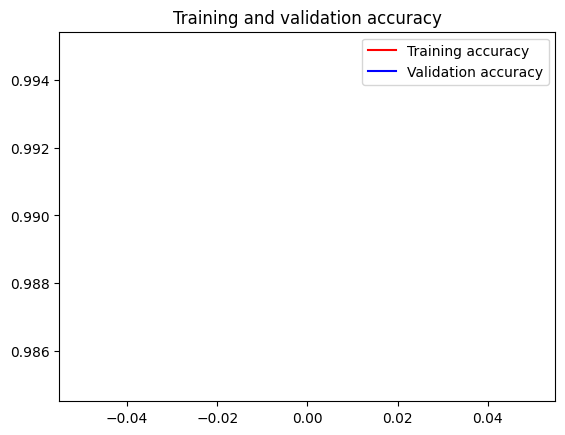

<Figure size 640x480 with 0 Axes>

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# detecting if a picture is a horse ot human

recall that -  if we have two folders named "horses" and "humans", the flow_from_directory function will assign binary label 0 to the "horses" category and binary label 1 to the "humans" category. This is because "horses" comes first alphabetically, so it gets assigned the label 0, and "humans" comes second, so it gets assigned the label 1.

In [37]:
# from keras.preprocessing.image import load_img, img_to_array

# image_path = work_path + f"tmp/validation/humans/valhuman02-01.png"
image_path =  work_path + f"tmp/training/horses/horse01-8.png"
image = keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
import numpy as np

image_array = keras.preprocessing.image.img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array /= 255.0

prediction = model.predict(image_array)

predicted_class = "humans" if prediction[0] > 0.5 else "other_class"
print(f"The predicted class is: {predicted_class}")
print(f"The prediction is: {prediction[0]}")

1/1 [==============================] - 2s 2s/step
The predicted class is: other_class
The prediction is: [4.0384834e-17]


In [38]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load the saved model
# model = keras.models.load_model("my_model.h5")

# Define the path to the folder containing the images to predict
folder_path = work_path + f"tmp/training/humans"

# Create a list of all the image file names in the folder
file_names = os.listdir(folder_path)

# Loop through each image file and make a prediction
for file_name in file_names:
    # Load the image and preprocess it
    image_path = os.path.join(folder_path, file_name)
    image = keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    image_array = keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array /= 255.0
    
    # Make the prediction
    prediction = model.predict(image_array)
    
    # Print the file name and prediction
    print(f"{file_name}: {prediction[0]}")


1/1 [==============================] - 0s 161ms/step
human01-00.png: [1.]
1/1 [==============================] - 0s 135ms/step
human01-01.png: [1.]
1/1 [==============================] - 0s 135ms/step
human01-02.png: [1.]
1/1 [==============================] - 0s 140ms/step
human01-03.png: [1.]
1/1 [==============================] - 0s 148ms/step
human01-04.png: [1.]
1/1 [==============================] - 0s 174ms/step
human01-05.png: [1.]
1/1 [==============================] - 0s 157ms/step
human01-06.png: [1.]
1/1 [==============================] - 0s 131ms/step
human01-07.png: [1.]
1/1 [==============================] - 0s 127ms/step
human01-08.png: [1.]
1/1 [==============================] - 0s 160ms/step
human01-09.png: [1.]
1/1 [==============================] - 0s 138ms/step
human01-10.png: [1.]
1/1 [==============================] - 0s 140ms/step
human01-11.png: [1.]
1/1 [==============================] - 0s 127ms/step
human01-12.png: [1.]
1/1 [==============================] -